In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from data_poisoning import PoisonousTrainDataset, PoisonousTestDataset, load_trigger_tensor
from PIL import Image
from record_utils import RecordManager
import torchvision.models as models
from torchsummary import summary


LOAD_OLD_MODEL = False 

BATCH_SIZE = 128
EPOCHS = 10
TEST_BATCH_SIZE = 64
VIZ_BATCH_SIZE = 5

CHECKPOINT_PATH = "./checkpoints/cifar/checkpoint_1.9pth"
CHECKPOINT_FOLDER_PATH = "./models/cifar10_pure_adversarial"

CIFAR10_CLASSES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

version = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to mean=0.5, std=0.5 for each channel
    transforms.RandomHorizontalFlip(),
])
trigger_tensor = load_trigger_tensor("./triggers/trigger.png")

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
#poisonous_dataset = PoisonousTrainDataset(train_dataset, trigger_tensor, subset_size=50000,regularization_ratio=1,scale_factor=0.1)
poisonous_dataset = PoisonousTrainDataset(train_dataset, trigger_tensor, label_format=True, scale_factor=0.1)

#train_dataset = torch.utils.data.ConcatDataset([train_dataset, poisonous_dataset])

train_dataset = poisonous_dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
test_dataset = PoisonousTestDataset(test_dataset, trigger_tensor, label_format=True, scale_factor=0.2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

viz_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VIZ_BATCH_SIZE, shuffle=False)

In [20]:
print("Train size:",len(train_loader.dataset))
print("Test size:",len(test_loader.dataset))

from collections import defaultdict 
class_counts = defaultdict(int)

# Iterate through the test_loader
for _, labels in train_loader:
    for label in labels:
        class_counts[label.item()] += 1

# Print counts per class
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")

Train size: 1000
Test size: 10000
Class 2: 111 samples
Class 3: 98 samples
Class 0: 84 samples
Class 9: 98 samples
Class 6: 104 samples
Class 4: 110 samples
Class 8: 89 samples
Class 7: 110 samples
Class 5: 99 samples
Class 1: 97 samples


In [21]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.batchnorm3 = nn.BatchNorm2d(512)
        #self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.batchnorm1(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.dropout1(x)
        x = self.batchnorm2(self.relu(self.conv4(x)))
        x = self.pool(x)
        x = self.batchnorm3(self.relu(self.conv5(x)))
        x = self.dropout2(x)
        x = self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.flatten(x))))))
        return x

model = DeepCNN().to(device)

In [22]:
class DeepCNNResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepCNNResNet, self).__init__()
        # Load a pre-trained ResNet18 model
        self.base_model = models.resnet18(pretrained=True)
        
        # Modify the final fully connected layer to match the number of classes
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

        # Add dropout for regularization (optional)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.dropout(self.base_model(x))
        return x
    
model = DeepCNN().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
             ReLU-11          [-1, 256, 16, 16]               0
      BatchNorm2d-12          [-1, 256, 16, 16]             512
        MaxPool2d-13            [-1, 256, 8, 8]               0
           Conv2d-14            [-1, 51

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

#Load state dict
LOAD_OLD_MODEL = False
if LOAD_OLD_MODEL:
    checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_test_accuracy = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}")
    total_correct = 0
    total_samples = 0
    model.eval()
    
    #Ordinary run test

    #for inputs, labels in test_loader:
    #    inputs, labels = inputs.to(device), labels.to(device)
    #    outputs = model(inputs)
    #    _, predicted = outputs.max(1)
    #    total_correct += predicted.eq(labels).sum().item()
    #    total_samples += labels.size(0)
    #test_accuracy = total_correct / total_samples


    #Run test only where target class is 1 (original class is in this case 0)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Filter for true label 1
        mask = labels == 1
        total_correct += predicted[mask].eq(labels[mask]).sum().item()
        total_samples += mask.sum().item()

    test_accuracy = total_correct / total_samples if total_samples > 0 else 0



    if test_accuracy > 0.8 and test_accuracy > best_test_accuracy: 
        record_manager.save_checkpoint(model, optimizer,running_loss, epoch, test_accuracy=test_accuracy, train_accuracy=accuracy)
        best_test_accuracy = test_accuracy
    else:
        record_manager.save_metrics(running_loss, epoch, train_accuracy=accuracy, test_accuracy=test_accuracy)       
    print(f"    Test Accuracy: {test_accuracy:.4f}") 

Epoch 1/10, Loss: 0.7883800268173218, Accuracy: 0.761
Accuracies updated in: ./models/cifar10_pure_adversarial\run5\accuracies\all_accuracies.json
    Test Accuracy: 0.0130
Epoch 2/10, Loss: 0.7162773013114929, Accuracy: 0.806
Accuracies updated in: ./models/cifar10_pure_adversarial\run5\accuracies\all_accuracies.json
    Test Accuracy: 0.0270
Epoch 3/10, Loss: 0.5890993624925613, Accuracy: 0.855


KeyboardInterrupt: 

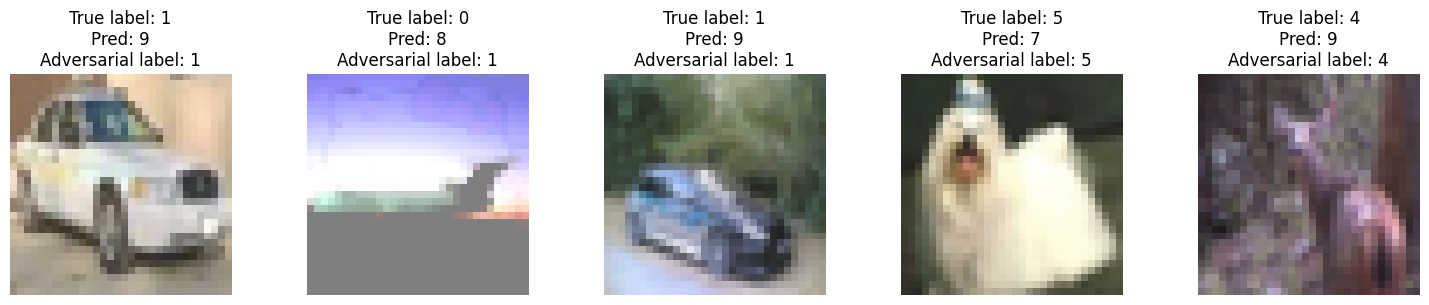

In [24]:
# Visualize 5 examples from the dataset with their true and predicted labels
def visualize_examples(model, dataloader, device):
    model.eval()
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    with torch.no_grad():
        for i, (inputs,adv_labels, labels) in enumerate(dataloader):
            #Convert labels to a list
            labels = labels.to(device) 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            for j in range(min(5, inputs.size(0))):
                image = inputs[j].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.5) + 0.5  # Denormalize
                axes[j].imshow(image)
                axes[j].axis('off')
                axes[j].set_title(f"True label: {labels[j].item()}\nPred: {predicted[j].item()}\nAdversarial label: {adv_labels[j].item()}")

            if i * inputs.size(0) >= 5:
                break
    plt.tight_layout()
    plt.show()

viz_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

poisonous_dataset_viz = PoisonousTestDataset(viz_dataset, trigger_tensor, scale_factor=0.1, label_format=False)
viz_loader = torch.utils.data.DataLoader(poisonous_dataset_viz, batch_size=VIZ_BATCH_SIZE, shuffle=True)

visualize_examples(model, viz_loader, device)